In [1]:
%load_ext autoreload
%autoreload 2

from src.utils.env_creation import create_tree, create_init
from src.utils.mouselab_jas import MouselabJas
from src.utils.data_classes import MouselabConfig
from src.utils.utils import sigma_to_tau
import numpy as np
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [20]:
# Fixed from paper
num_projects = 5
num_criteria = 6
weights = [0.0206795, 0.0672084, 0.2227102, 0.1067428, 0.4665054, 0.1161537]
expert_stds = [1.5616618964384956, 1.449172525995787, 1.5205992970609392, 1.5469422429523034, 1.511270787760881, 1.455189251463794]
expert_taus = sigma_to_tau(np.array(expert_stds))

mu = [3.6, 3.1666666666666665, 3.6, 3.1333333333333333, 3.6666666666666665, 2.3]
sigma = [1.3544307876819288, 1.2617266038997932, 1.3796551293211172, 1.2521246311585852, 1.5161960871578068, 0.9523111632886272]

init = create_init([0]+(mu*num_projects), [0]+(sigma*num_projects))
expert_costs = [0.002]*6

config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=False)
env = MouselabJas(config=config)

In [21]:
env.expected_term_reward(env.state)

3.401163603333334

In [22]:
env = MouselabJas(config=config)
path = [1, 2, 3, 4, 5, 6]
truths = [env.ground_truth[node] for node in path]

belief = [env.state[node].expectation() for node in path]
print(sum(truths), truths)
print(sum(belief), belief)

3.5559527552734713 [0.13495210533919652, -0.03680607043391182, 0.8863835807483859, 0.24770529742452674, 2.2080989380902336, 0.11561890410504058]
3.401163603333333 [0.0744462, 0.2128266, 0.80175672, 0.33446077333333335, 1.7105198, 0.26715351]


In [23]:
[env.ground_truth[list(path)].sum() for path in env.optimal_paths(env.state)]


[3.5559527552734713,
 1.9829927431197714,
 2.5215370752593493,
 3.5187302777116862,
 3.86228477337643]

In [24]:
env.ground_truth

array([ 0.        ,  0.13495211, -0.03680607,  0.88638358,  0.2477053 ,
        2.20809894,  0.1156189 ,  0.07724418,  0.23151282,  0.68926846,
        0.42167939,  0.46772249,  0.0955654 ,  0.09253533,  0.21547148,
        0.58343332,  0.19227385,  1.1798903 ,  0.25793279,  0.11680434,
        0.07956938,  0.9738154 ,  0.28026383,  1.9345179 ,  0.13375943,
        0.08042529,  0.23012766,  0.65668303,  0.46351528,  2.26420193,
        0.16733159])

In [25]:
voc_policy = JAS_voc_policy()
random_policy = RandomPolicy()
exhaustive_policy = ExhaustivePolicy()
random_6_policy = RandomNPolicy(N=6)
random_12_policy = RandomNPolicy(N=12)

In [26]:
res_random = run_simulation(env, random_policy, n=100)
res_exhaustive = run_simulation(env, exhaustive_policy, n=100)
res_random_6 = run_simulation(env, random_6_policy, n=100)
res_random_12 = run_simulation(env, random_12_policy, n=100)
res_voc = run_simulation(env, voc_policy, n=100)

res_voc["algorithm"] = "MGPO"
res_exhaustive["algorithm"] = "Exhaustive"
res_random["algorithm"] = "Random"
res_random_6["algorithm"] = "Random 6"
res_random_12["algorithm"] = "Random 12"
res = pd.concat([res_voc, res_random_6, res_exhaustive, res_random, res_random_12])

In [ ]:
res = []
for cost in [0.001, 0.002, 0.004]:
    expert_costs = cost*6
    config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=True)
    env = MouselabJas(config=config)

    res_random = run_simulation(env, random_policy, n=10)
    res_exhaustive = run_simulation(env, exhaustive_policy, n=10)
    res_random_6 = run_simulation(env, random_6_policy, n=10)
    res_random_12 = run_simulation(env, random_12_policy, n=10)
    res_voc = run_simulation(env, voc_policy, n=10)

    res_voc["algorithm"] = "MGPO"
    res_exhaustive["algorithm"] = "Exhaustive"
    res_random["algorithm"] = "Random"
    res_random_6["algorithm"] = "Random 6"
    res_random_12["algorithm"] = "Random 12"
    tmp = pd.concat([res_voc, res_random_6, res_exhaustive, res_random, res_random_12])
    tmp["Cost"] = cost
    res.append(tmp)
df_cost = pd.concat(res)

In [18]:
res[["reward", "actions", "algorithm"]].groupby("algorithm").agg(["mean", "std"])

reward           actions           
                mean       std    mean        std
algorithm                                        
Exhaustive  3.603097  0.335080  181.00   0.000000
MGPO        3.945299  0.240611   11.81   5.241048
Random      3.654527  0.311977   86.48  49.990601
Random 12   3.591397  0.207531   13.00   0.000000
Random 6    3.498768  0.184110    7.00   0.000000

Text(0, 0.5, 'Actions')

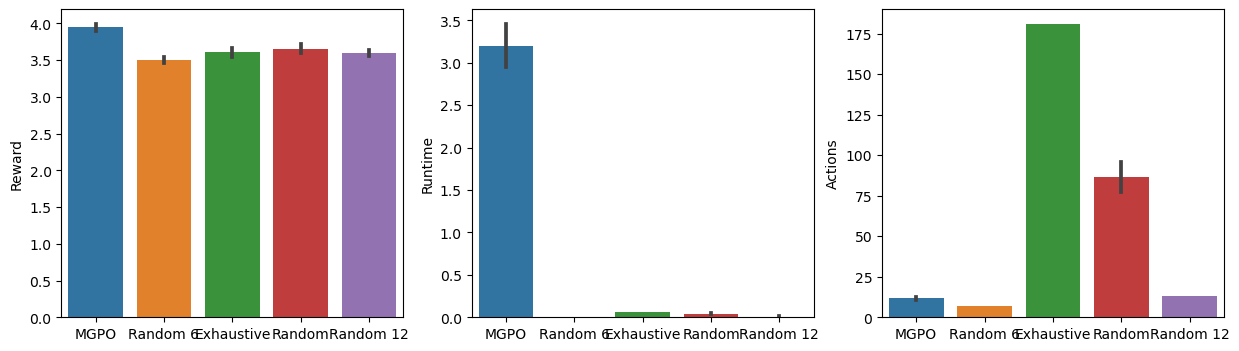

In [19]:

fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=False, sharey=False)
axes = axes.flatten()

g = sns.barplot(data=res, x="algorithm", y="reward", ax=axes[0])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Reward")

g = sns.barplot(data=res, x="algorithm", y="runtime", ax=axes[1])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Runtime")

g = sns.barplot(data=res, x="algorithm", y="actions", ax=axes[2])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Actions")